<a href="https://colab.research.google.com/github/sravangvm/Covid-Classification-Using-X-Rays/blob/main/CovidX_Ray_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle

In [9]:
! cp kaggle.json ~/.kaggle/

In [10]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

In [ ]:
!unzip /content/covid19-radiography-database.zip

In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.metrics import *
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import load_img

import numpy as np
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import cv2

import os

In [91]:
covid_image_path = 'COVID-19_Radiography_Dataset/COVID/images/'
normal_image_path = 'COVID-19_Radiography_Dataset/Normal/images/'

# Paths to masks
covid_mask_path = 'COVID-19_Radiography_Dataset/COVID/masks/'
normal_mask_path = 'COVID-19_Radiography_Dataset/Normal/masks/'

# All paths to images and masks
all_image_paths = [[covid_image_path+file for file in os.listdir(covid_image_path)]
                   +[normal_image_path+file for file in os.listdir(normal_image_path)]
                   +[pneumonia_image_path+file for file in os.listdir(pneumonia_image_path)]
                   +[lung_opacity_image_path+file for file in os.listdir(lung_opacity_image_path)]
                  ][0]
all_mask_paths = [[covid_mask_path+file for file in os.listdir(covid_mask_path)]
                  +[normal_mask_path+file for file in os.listdir(normal_mask_path)]
                  +[pneumonia_mask_path+file for file in os.listdir(pneumonia_mask_path)]
                  +[lung_opacity_mask_path+file for file in os.listdir(lung_opacity_mask_path)]
                 ][0]

# Shuffle the arrays
all_image_paths, all_mask_paths = shuffle(all_image_paths, all_mask_paths)

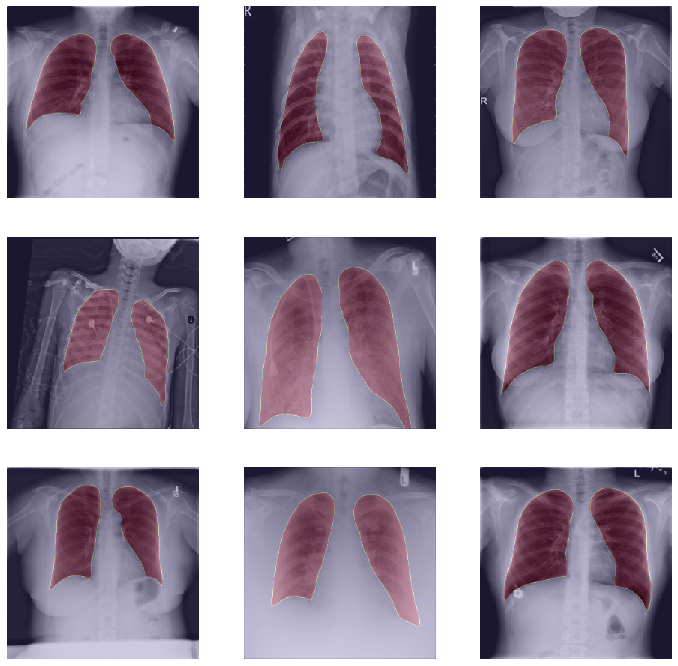

In [92]:
IMAGE_SIZE = 256

def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = np.mean(image, axis=-1)/255.0
        images.append(image)
    return np.array(images)

fig = plt.figure(figsize=(12, 12))
c = 3
r = 3
for i in range(1, c*r +1):
    fig.add_subplot(r, c, i)
    plt.axis('off')
    plt.imshow(open_images([all_image_paths[i-1]])[0], cmap='gray', interpolation='none')
    plt.imshow(open_images([all_mask_paths[i-1]])[0], cmap='Spectral_r', alpha=0.3)
plt.show()

In [93]:
train_image_paths = all_image_paths[:17000]
train_mask_paths = all_mask_paths[:17000]
val_image_paths = all_image_paths[17000:]
val_mask_paths = all_mask_paths[17000:]

def datagen(image_paths, mask_paths, batch_size=16):
    for x in range(0, len(image_paths), batch_size):
        images = open_images(image_paths[x:x+batch_size]).reshape(-1,IMAGE_SIZE, IMAGE_SIZE, 1)
        masks = open_images(mask_paths[x:x+batch_size]).reshape(-1,IMAGE_SIZE, IMAGE_SIZE, 1)
        yield images, masks

In [94]:
img_input = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))

x1 = Conv2D(64, (3,3), activation='relu', padding='same')(img_input)
x1 = Conv2D(64, (3,3), activation='relu', padding='same')(x1)
x1_pool = MaxPool2D((2,2))(x1)

x2 = Conv2D(128, (3,3), activation='relu', padding='same')(x1_pool)
x2 = Conv2D(128, (3,3), activation='relu', padding='same')(x2)
x2_pool = MaxPool2D((2,2))(x2)

x3 = Conv2D(256, (3,3), activation='relu', padding='same')(x2_pool)
x3 = Conv2D(256, (3,3), activation='relu', padding='same')(x3)
x3 = Conv2D(256, (3,3), activation='relu', padding='same')(x3)
x3_pool = MaxPool2D((2,2))(x3)

x4 = Conv2D(256, (3,3), activation='relu', padding='same')(x3_pool)
x4 = Conv2D(256, (3,3), activation='relu', padding='same')(x4)
x4 = Conv2D(256, (3,3), activation='relu', padding='same')(x4)
x4_pool = UpSampling2D((2,2))(x4)

x5 = Concatenate()([x4_pool, x3])
x5 = Conv2D(128, (3,3), activation='relu', padding='same')(x5)
x5 = Conv2D(128, (3,3), activation='relu', padding='same')(x5)
x5_pool = UpSampling2D((2,2))(x5)

x6 = Concatenate()([x5_pool, x2])
x6 = Conv2D(64, (3,3), activation='relu', padding='same')(x6)
x6 = Conv2D(64, (3,3), activation='relu', padding='same')(x6)
x6_pool = UpSampling2D((2,2))(x6)

x7 = Concatenate()([x6_pool, x1])
x7 = Conv2D(64, (3,3), activation='relu', padding='same')(x7)
x7 = Conv2D(64, (3,3), activation='relu', padding='same')(x7)
x7 = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x7)

model = Model(img_input, x7)

In [95]:
def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=[iou_coef,"accuracy"])

In [96]:
batch_size = 20
steps = int(len(train_image_paths)/batch_size)
epochs = 2
for _ in range(epochs):
    model.fit(datagen(train_image_paths, train_mask_paths, batch_size=batch_size), epochs=1, steps_per_epoch=steps)

850/850 [==============================] - 595s 699ms/step - loss: 0.0513 - iou_coef: 0.8789 - accuracy: 0.9804


In [97]:
batch_size = 20
steps = int(len(val_image_paths)/batch_size)
model.evaluate(datagen(val_image_paths, val_mask_paths, batch_size=batch_size), steps=steps)

208/208 [==============================] - 54s 256ms/step - loss: 0.0388 - iou_coef: 0.9075 - accuracy: 0.9851


[0.03876587748527527, 0.9075345396995544, 0.9851354956626892]